In [1]:
# Import Libraries:

import numpy as np
import pandas as pd
import seaborn as sn
import xgboost as xgb
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
#import graphviz
import shap
import sklearn

from sklearn import ensemble
from sklearn.inspection import plot_partial_dependence
from matplotlib.colors import ListedColormap
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from skopt import BayesSearchCV
from IPython.display import Image
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve
from sklearn.inspection import permutation_importance
from scipy import stats
from xgboost import plot_importance
from alibi.explainers import KernelShap

# Susceptibility to induced seismicity 

## Geoscience BC project

In [2]:
df_GHFraw = pd.read_csv('Geological_Operational_Likelihood.csv')

In [3]:
imputer = SimpleImputer(strategy="median")
imputer.fit(df_GHFraw)
df_GHF_imp = imputer.transform(df_GHFraw)
df_GHF_imp = pd.DataFrame(df_GHF_imp, columns = df_GHFraw.columns)

In [4]:
z_scores = stats.zscore(df_GHF_imp)  #calculate z-scores of `df`

abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
df_GHF = df_GHF_imp[filtered_entries]
df_GHF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3353 entries, 1 to 4409
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Well_ID            3353 non-null   float64
 1   LATITUDE           3353 non-null   float64
 2   LONGITUDE          3353 non-null   float64
 3   Max_Inj_P          3353 non-null   float64
 4   Avg_Inj_Rate       3353 non-null   float64
 5   Active_Days        3353 non-null   float64
 6   Total_Prop         3353 non-null   float64
 7   Avg_Prop/Stage     3353 non-null   float64
 8   Total_Volume       3353 non-null   float64
 9   Avg_Volume/Stage   3353 non-null   float64
 10  Number_Stages      3353 non-null   float64
 11  Comp_Length        3353 non-null   float64
 12  Avg_Frac_Spacing   3353 non-null   float64
 13  Avg_Vol/Meter      3353 non-null   float64
 14  Avg_Prop/Meter     3353 non-null   float64
 15  Well_Shmax_Azdiff  3353 non-null   float64
 16  TVD                3353 

## Data split and preprocessing (imputation and scaling)

In [5]:
train, test = train_test_split(df_GHF, test_size=0.25,random_state=12345) #splitting dataset (75% training size)
X_train = train.drop(columns=['Label','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_train = train['Label']
X_test = test.drop(columns=['Label','Montney-Mid','Lower_Form','Dist_Lower_Form','WellDensity-5km','Well_ID','LATITUDE','LONGITUDE'])
y_test = test['Label']


In [6]:
#imputer = SimpleImputer(strategy="median")
#imputer.fit(X_train)
#X_train_imp = imputer.transform(X_train)
#X_test_imp = imputer.transform(X_test)

scaler = StandardScaler() # create feature trasformer object
scaler.fit(X_train) # fitting the transformer on the train split 
X_train_scaled = scaler.transform(X_train) # transforming the train split
X_test_scaled = scaler.transform(X_test) # transforming the test split

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns)

In [7]:
X_train.columns

Index(['Max_Inj_P', 'Avg_Inj_Rate', 'Active_Days', 'Total_Prop',
       'Avg_Prop/Stage', 'Total_Volume', 'Avg_Volume/Stage', 'Number_Stages',
       'Comp_Length', 'Avg_Frac_Spacing', 'Avg_Vol/Meter', 'Avg_Prop/Meter',
       'Well_Shmax_Azdiff', 'TVD', 'Bulk_Density', 'BHCPv', 'Gamma_Ray',
       'b_value', 'Seismo_index', 'Shear_Strain', 'Shmin', 'Shmax_variation',
       'PP_grad', 'ppgrad_SD', 'Montney-Top', 'Basement_Top', 'Dist_Faults',
       'Dist_CTB', 'Max_ISIP', 'Max_Pb', 'Dist_TopMon', 'Dist_MidMon',
       'Dist_Basement', 'Mon_Thickness', 'WellDensity-1km', 'WellDensity-3km',
       'WellDensity-10km'],
      dtype='object')

## Data Before Scaling

In [7]:
pd.DataFrame(X_train, columns = X_train.columns).head()

,Max_Injection_Pressure,Avg_rate,Active_Days,Total_Propant,Avg_Propant/Stage,Total_Volume,Avg_Volume/Stage,Number_Stages,Complition_Length,Avg_Frac_Spacing,...,Dist_CTB,Max_ISIP,Max_Pb,Dist_TopMon,Dist_MidMon,Dist_Basement,Mon_Thickness,WellDensity-1km,WellDensity-3km,WellDensity-10km
758,62.2,14.100000,117.0,1706.0,100.35,10606.80,623.93,17.0,1521.000,90.63,...,10.10,36.10,57.00,5.49,-59.79,-1825.00,324.81,0.0,4.0,22.0
4002,59.1,10.517647,66.0,1233.7,77.11,21741.70,1358.86,16.0,1575.340,92.79,...,13.32,27.50,51.60,36.55,-25.31,-1750.50,282.94,0.0,0.0,5.0
3537,62.0,8.510357,41.0,900.0,100.00,1180.41,131.16,9.0,1765.445,97.80,...,77.52,32.46,51.08,297.66,148.32,-1299.30,292.29,0.0,7.0,68.0
1181,69.0,5.331250,100.0,1900.0,135.71,12798.80,914.20,14.0,1683.740,126.17,...,89.41,60.20,63.80,300.61,195.30,-1404.04,301.50,0.0,2.0,58.0
3257,76.9,11.776923,91.0,5761.0,240.04,27245.70,1135.24,24.0,1905.500,83.50,...,29.83,38.00,77.00,185.89,147.24,-1742.90,286.75,2.0,12.0,166.0


## Data After Scaling

In [8]:
pd.DataFrame(X_train_scaled, columns = X_train.columns).head()

,Max_Injection_Pressure,Avg_rate,Active_Days,Total_Propant,Avg_Propant/Stage,Total_Volume,Avg_Volume/Stage,Number_Stages,Complition_Length,Avg_Frac_Spacing,...,Dist_CTB,Max_ISIP,Max_Pb,Dist_TopMon,Dist_MidMon,Dist_Basement,Mon_Thickness,WellDensity-1km,WellDensity-3km,WellDensity-10km
0,-0.123589,3.048785,1.204887,-0.215326,-0.238530,-0.136155,-0.128419,-0.248539,-0.696392,-0.382620,...,-1.443330,0.199977,0.044714,-1.015784,-0.574666,-0.921803,1.229558,-0.324493,0.174124,-0.305460
1,-0.611692,1.126382,-0.116760,-0.631387,-0.659342,1.593534,1.518001,-0.338222,-0.563684,-0.342693,...,-1.348457,-0.630676,-0.600024,-0.689559,-0.212541,-0.577262,-0.489767,-0.324493,-0.520164,-0.624890
2,-0.155079,0.049206,-0.764627,-0.925352,-0.244868,-1.600444,-1.232343,-0.966008,-0.099414,-0.250083,...,0.543094,-0.151602,-0.662110,2.052892,1.611003,1.509409,-0.105824,-0.324493,0.694841,0.558878
3,0.947091,-1.656803,0.764338,-0.044426,0.401741,0.204349,0.521855,-0.517590,-0.298952,0.274334,...,0.893414,2.527736,0.856605,2.083876,2.104409,1.025016,0.272370,-0.324493,-0.173020,0.370979
4,2.190968,1.802149,0.531106,3.356828,2.290867,2.448522,1.017038,0.379247,0.242625,-0.514418,...,-0.862016,0.383493,2.432630,0.878966,1.599660,-0.542114,-0.333315,2.337092,1.562701,2.400296


In [7]:
# Calculating Scores
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation
    """
    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


results = dict()

# Hyperparameter Optimization
- Bayesian search with Balanced class weight


In [13]:
import warnings
warnings.filterwarnings('ignore')
#### Logistic regression

optlr = BayesSearchCV(
    LogisticRegression(class_weight='balanced'),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'max_iter': (1e+2, 1e+5, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optlr.fit(X_train_scaled, y_train)

print("LR train score: %s" % optlr.best_score_)
print("LR test score: %s" % optlr.score(X_test_scaled, y_test))
print("LR best params: %s" % str(optlr.best_params_))

##### Decision Tree

optdt = BayesSearchCV(
    DecisionTreeClassifier(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optdt.fit(X_train_scaled, y_train)

print("DT train score: %s" % optdt.best_score_)
print("DT test score: %s" % optdt.score(X_test_scaled, y_test))
print("DT best params: %s" % str(optdt.best_params_))


##### Random Forest

optrf = BayesSearchCV(
    RandomForestClassifier(),
    {
        'max_depth': (1, 100, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optrf.fit(X_train_scaled, y_train)

print("RF train score: %s" % optrf.best_score_)
print("RF test score: %s" % optrf.score(X_test_scaled, y_test))
print("RF best params: %s" % str(optrf.best_params_))


##### SVC
optsvc = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        #'degree': (1, 8),  # integer valued parameter
        #'kernel': ['linear', 'poly', 'rbf'],  # categorical parameter
    },
    n_iter=32,
    cv=5
)

optsvc.fit(X_train_scaled, y_train)

print("SVC train score: %s" % optsvc.best_score_)
print("SVC test score: %s" % optsvc.score(X_test_scaled, y_test))
print("SVC best params: %s" % str(optsvc.best_params_))

###### KNN

optknn = BayesSearchCV(
    KNeighborsClassifier(),
    {
        'n_neighbors': (3, 10, 'log-uniform'),
        'leaf_size': (10, 50, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optknn.fit(X_train_scaled, y_train)

print("KNN Opt train score: %s" % optknn.best_score_)
print("KNN Opt test score: %s" % optknn.score(X_test_scaled, y_test))
print("KNN Opt best params: %s" % str(optknn.best_params_))



LR train score: 0.6833731105807478
LR test score: 0.700834326579261
LR best params: OrderedDict([('C', 0.0038497807034949764), ('max_iter', 356.95364462436913)])
DT train score: 0.8476531424025457
DT test score: 0.8510131108462455
DT best params: OrderedDict([('max_depth', 70)])
RF train score: 0.8926014319809069
RF test score: 0.9094159713945172
RF best params: OrderedDict([('max_depth', 62)])
SVC train score: 0.8858392999204455
SVC test score: 0.8915375446960667
SVC best params: OrderedDict([('C', 141927.1570277046), ('gamma', 0.08153866243831843)])
KNN Opt train score: 0.8428798727128083
KNN Opt test score: 0.865315852205006
KNN Opt best params: OrderedDict([('leaf_size', 22), ('n_neighbors', 4)])


In [8]:

optgb = BayesSearchCV(
    ensemble.GradientBoostingClassifier(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'n_estimators': (10, 1000, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optgb.fit(X_train_scaled, y_train)

print("GB Opt train score: %s" % optgb.best_score_)
print("GB Opt test score: %s" % optgb.score(X_test_scaled, y_test))
print("GB Opt best params: %s" % str(optgb.best_params_))

The objective has been evaluated at this point before.
The objective has been evaluated at this point before.
The objective has been evaluated at this point before.


GB Opt train score: 0.8973747016706444
GB Opt test score: 0.9094159713945172
GB Opt best params: OrderedDict([('learning_rate', 0.3686609631447846), ('n_estimators', 1000)])


In [11]:
##### XGBoost

optxgb = BayesSearchCV(
    xgb.XGBClassifier(eval_metric='logloss',use_label_encoder=False),
    {
        'eta': (1e-6, 0.9, 'log-uniform'),
        'gamma': (1e-6, 1e+6, 'log-uniform'),
        'max_depth': (8, 32, 'log-uniform'),
    },
    n_iter=32,
    cv=5
)

optxgb.fit(X_train_scaled, y_train)

print("XGB Opt train score: %s" % optxgb.best_score_)
print("XGB Opt test score: %s" % optxgb.score(X_test_scaled, y_test))
print("XGB Opt best params: %s" % str(optxgb.best_params_))

XGB Opt train score: 0.9005568814638027
XGB Opt test score: 0.8951132300357568
XGB Opt best params: OrderedDict([('eta', 0.3715548932087601), ('gamma', 1e-06), ('max_depth', 32)])


In [53]:
### lightgbm.LGBMClassifier
optlgb = BayesSearchCV(
    lgb.LGBMClassifier(),
    {
        'learning_rate': (1e-6, 0.9, 'log-uniform'),
        'num_leaves': (10, 80, 'log-uniform'),
        'max_depth': (8, 32, 'log-uniform'),
#        'n_estimators': (10, 1000, 'log-uniform'),
    },
    n_iter=32,#32
    cv=5  #5
)

optlgb.fit(X_train_scaled, y_train)

print("LGB Opt train score: %s" % optlgb.best_score_)
print("LGB Opt test score: %s" % optlgb.score(X_test_scaled, y_test))
print("LGB Opt best params: %s" % str(optlgb.best_params_))

LGB Opt train score: 0.9196499602227526
LGB Opt test score: 0.9165673420738975
LGB Opt best params: OrderedDict([('learning_rate', 0.2635459292621476), ('max_depth', 100), ('num_leaves', 200)])


In [49]:
scoring = "f1"
scoring_list = ["accuracy", "recall", "precision", "f1"] 

models = {
        
    
    'Dummy_Classifier'   : DummyClassifier(strategy="most_frequent"),
    'LogisticRegression' : LogisticRegression(C=0.0038497807034949764, max_iter=356,class_weight='balanced'),
    'decision tree'      : DecisionTreeClassifier(max_depth= 70),
    'random forest'      : RandomForestClassifier(max_depth= 62),
#    'random forest2'      : RandomForestClassifier(max_depth= 28),
    'SVC'                : SVC(C= 141927.1570277046,gamma=0.08153866243831843),
    'KNN'                : KNeighborsClassifier(leaf_size= 22,n_neighbors= 4), 
    'XGBoost'            : xgb.XGBClassifier(eta= 0.3715548932087601,gamma= 1e-06 , max_depth=32,eval_metric='logloss'),
    'lightGBM'           : lgb.LGBMClassifier(learning_rate= 0.163,max_depth= 32,num_leaves= 100) #### balanced class weight
         }

scoresAll = dict()

for model_name, model in models.items():
    print(model_name)
    scoresAll[model_name] = mean_std_cross_val_scores(model, X_train_scaled, y_train, return_train_score=True, cv=50, scoring=scoring_list)

pd.DataFrame.from_dict(scoresAll, orient='index')

Dummy_Classifier


Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


LogisticRegression
decision tree
random forest
SVC
KNN
XGBoost


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


lightGBM


,fit_time,score_time,test_accuracy,train_accuracy,test_recall,train_recall,test_precision,train_precision,test_f1,train_f1
Dummy_Classifier,0.001 (+/- 0.000),0.003 (+/- 0.000),0.789 (+/- 0.009),0.789 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
LogisticRegression,0.013 (+/- 0.002),0.007 (+/- 0.001),0.679 (+/- 0.071),0.687 (+/- 0.002),0.707 (+/- 0.134),0.726 (+/- 0.005),0.372 (+/- 0.080),0.376 (+/- 0.002),0.484 (+/- 0.089),0.495 (+/- 0.003)
decision tree,0.057 (+/- 0.009),0.005 (+/- 0.001),0.848 (+/- 0.063),1.000 (+/- 0.000),0.601 (+/- 0.155),1.000 (+/- 0.000),0.668 (+/- 0.154),1.000 (+/- 0.000),0.624 (+/- 0.138),1.000 (+/- 0.000)
random forest,0.629 (+/- 0.017),0.013 (+/- 0.001),0.898 (+/- 0.034),1.000 (+/- 0.000),0.590 (+/- 0.140),1.000 (+/- 0.000),0.896 (+/- 0.096),1.000 (+/- 0.000),0.702 (+/- 0.115),1.000 (+/- 0.000)
SVC,0.314 (+/- 0.009),0.008 (+/- 0.000),0.891 (+/- 0.042),1.000 (+/- 0.000),0.656 (+/- 0.122),1.000 (+/- 0.000),0.799 (+/- 0.124),1.000 (+/- 0.000),0.715 (+/- 0.110),1.000 (+/- 0.000)
KNN,0.018 (+/- 0.001),0.014 (+/- 0.001),0.856 (+/- 0.036),0.913 (+/- 0.001),0.546 (+/- 0.126),0.678 (+/- 0.006),0.719 (+/- 0.127),0.881 (+/- 0.004),0.611 (+/- 0.102),0.766 (+/- 0.004)
XGBoost,0.381 (+/- 0.016),0.010 (+/- 0.000),0.905 (+/- 0.038),1.000 (+/- 0.000),0.684 (+/- 0.133),1.000 (+/- 0.000),0.843 (+/- 0.116),1.000 (+/- 0.000),0.748 (+/- 0.107),1.000 (+/- 0.000)
lightGBM,0.457 (+/- 0.020),0.009 (+/- 0.001),0.914 (+/- 0.040),1.000 (+/- 0.000),0.707 (+/- 0.139),1.000 (+/- 0.000),0.863 (+/- 0.104),1.000 (+/- 0.000),0.771 (+/- 0.111),1.000 (+/- 0.000)


# Model performance after hyperparameter optimization

In [15]:
table = pd.DataFrame.from_dict(scoresAll, orient='index').drop(columns=['fit_time','score_time','train_accuracy','train_f1','train_precision','train_recall'])
table.to_excel("output.xlsx")
table

,test_accuracy,test_recall,test_precision,test_f1
Dummy_Classifier,0.789 (+/- 0.009),0.000 (+/- 0.000),0.000 (+/- 0.000),0.000 (+/- 0.000)
LogisticRegression,0.679 (+/- 0.071),0.707 (+/- 0.134),0.372 (+/- 0.080),0.484 (+/- 0.089)
decision tree,0.847 (+/- 0.053),0.599 (+/- 0.150),0.656 (+/- 0.139),0.620 (+/- 0.130)
random forest,0.895 (+/- 0.034),0.589 (+/- 0.142),0.881 (+/- 0.102),0.696 (+/- 0.116)
SVC,0.891 (+/- 0.042),0.656 (+/- 0.122),0.799 (+/- 0.124),0.715 (+/- 0.110)
KNN,0.856 (+/- 0.036),0.546 (+/- 0.126),0.719 (+/- 0.127),0.611 (+/- 0.102)
XGBoost,0.905 (+/- 0.038),0.684 (+/- 0.133),0.843 (+/- 0.116),0.748 (+/- 0.107)
lightGBM,0.919 (+/- 0.039),0.724 (+/- 0.124),0.877 (+/- 0.111),0.788 (+/- 0.105)


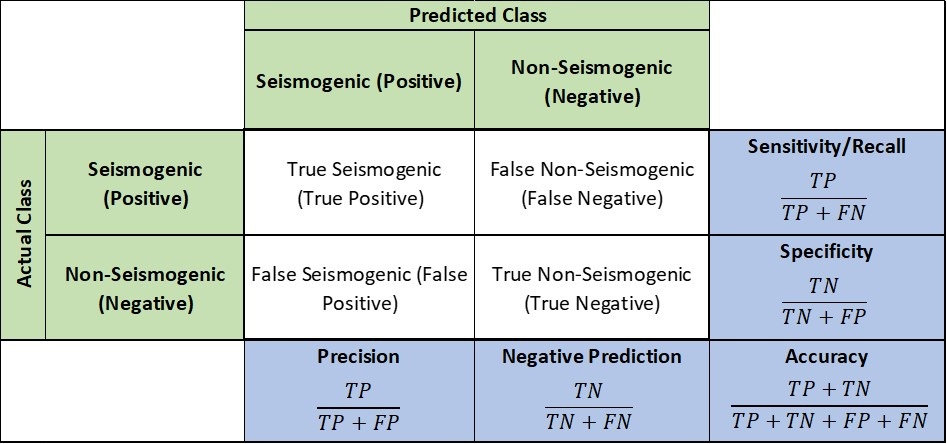

# Best model: Light GBM, XGBoost and SVC


# Model performance on validation set

F1 Score: Random Forest [0.93857143 0.69064748]
F1 Score: SVC [0.93420101 0.69152542]
F1 Score: XGBoost [0.93641618 0.70068027]
F1 Score: Light GBM [0.94883041 0.77419355]


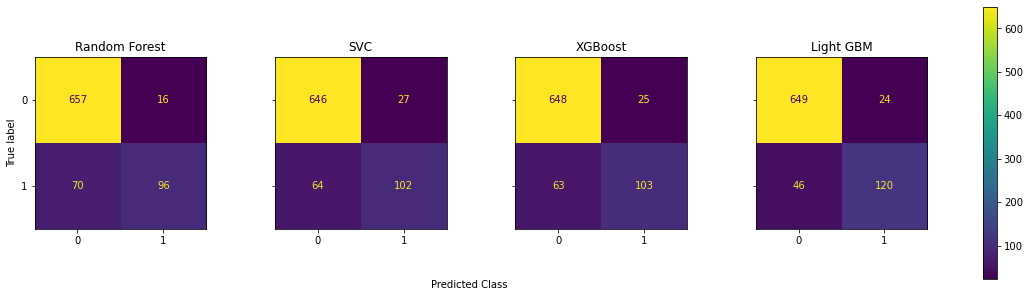

In [55]:
classifiers = {
    "Random Forest": RandomForestClassifier(max_depth= 62),
    'SVC': SVC(C= 141927.1570277046,gamma=0.08153866243831843),
    "XGBoost": xgb.XGBClassifier(eta= 0.3715548932087601,gamma= 1e-06 , max_depth=32,eval_metric='logloss',use_label_encoder=False),
    "Light GBM": lgb.LGBMClassifier(learning_rate= 0.06649007425065066,max_depth= 8,n_estimators=1000,num_leaves= 100,class_weight='balanced')
                }


f, axes = plt.subplots(1, 4, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_scaled, y_train).predict(X_test_scaled)
    print("F1 Score: %s" % key , f1_score(y_test, y_pred, average=None))
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix)
#                                  display_labels=iris.target_names)
    disp.plot(ax=axes[i], xticks_rotation=0)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted Class', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()
f.savefig('Validation_ConfMatrix_GOP4_300dpi', dpi=300)

# Model Interpretation

In [9]:
#model = lgb.LGBMClassifier(learning_rate= 0.06649007425065066,max_depth= 8,n_estimators=1000,num_leaves= 100,class_weight='balanced').fit(X_train_scaled, y_train)
#lgb.plot_importance(model)
#fig = plt.gcf()
#plt.title("Light GBM Classifier Feature Importance with Split")
#fig.set_figheight(6)
#fig.set_figwidth(12)
#lt.savefig('LGB_C_FIsplit_200dpi.png', dpi=200)


## FI-SVC

In [ ]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

features_names = [X_train.columns]
svm = SVC(C= 141927.1570277046,gamma=0.08153866243831843,kernel='linear')
svm.fit(X_train_scaled, y_train)
f_importances(svm.coef_, features_names)

In [ ]:
feature_names = [f'feature {i}' for i in range(X_train_scaled.shape[1])]
modelsvm = SVC(C= 141927.1570277046,gamma=0.08153866243831843,kernel='linear')
modelsvm.fit(X_train_scaled, y_train)

## FI - Light GBM

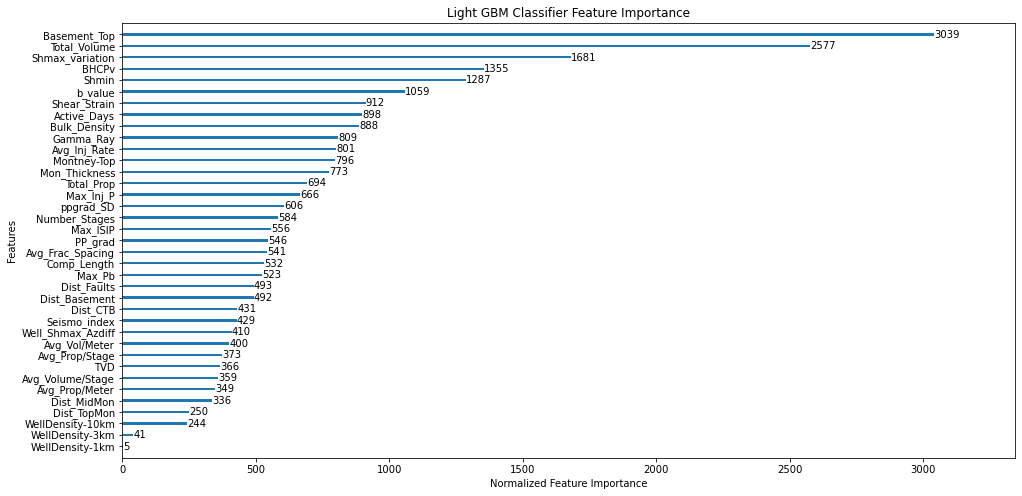

In [28]:
model = lgb.LGBMClassifier(learning_rate= 0.06649007425065066,max_depth= 8,n_estimators=1000,num_leaves= 100,class_weight='balanced').fit(X_train_scaled, y_train)
lgb.plot_importance(model, importance_type='gain', grid=False ,precision=0)
fig = plt.gcf()
plt.title("Light GBM Classifier Feature Importance")
plt.xlabel("Normalized Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('LGBM_C_FI_GOP_200dpi.png', dpi=200)

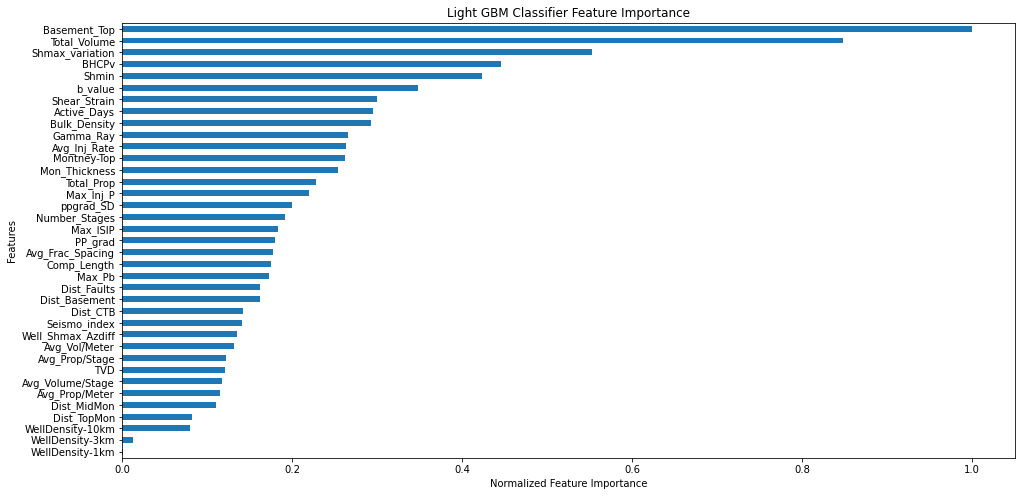

In [53]:
model = lgb.LGBMClassifier(learning_rate= 0.06649007425065066,max_depth= 8,n_estimators=1000,num_leaves= 100,class_weight='balanced',importance_type='gain')
model.fit(X_train_scaled, y_train)
#feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns})
feat_importances = pd.Series(model.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Light GBM Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('LGBM_C_FI_GOP_200dpi.png', dpi=200)

## FI - Random Forest

In [11]:
feature_names = [f'feature {i}' for i in range(X_train_scaled.shape[1])]
forest = RandomForestClassifier(max_depth= 62)
forest.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=62)

In [11]:
#importances = forest.feature_importances_
#std = np.std([
#    tree.feature_importances_ for tree in forest.estimators_], axis=0)
#forest_importances = pd.Series(importances, index=feature_names)

#fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax)
#ax.set_title("Feature importances using MDI")
#ax.set_ylabel("Mean decrease in impurity")
#fig.tight_layout()

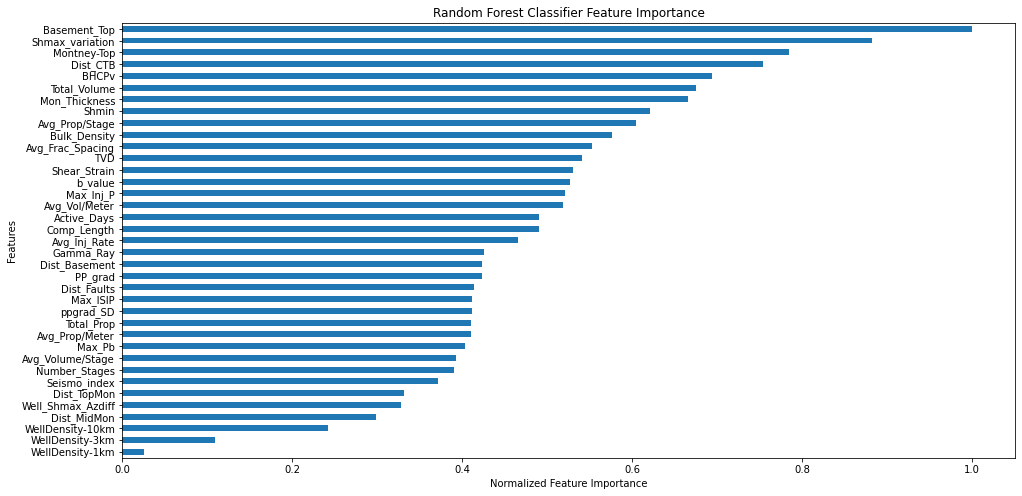

In [15]:
feat_importances = pd.Series(forest.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("Random Forest Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('RF_C_FI_GOP_200dpi.png', dpi=200)

## FI - XGBoost

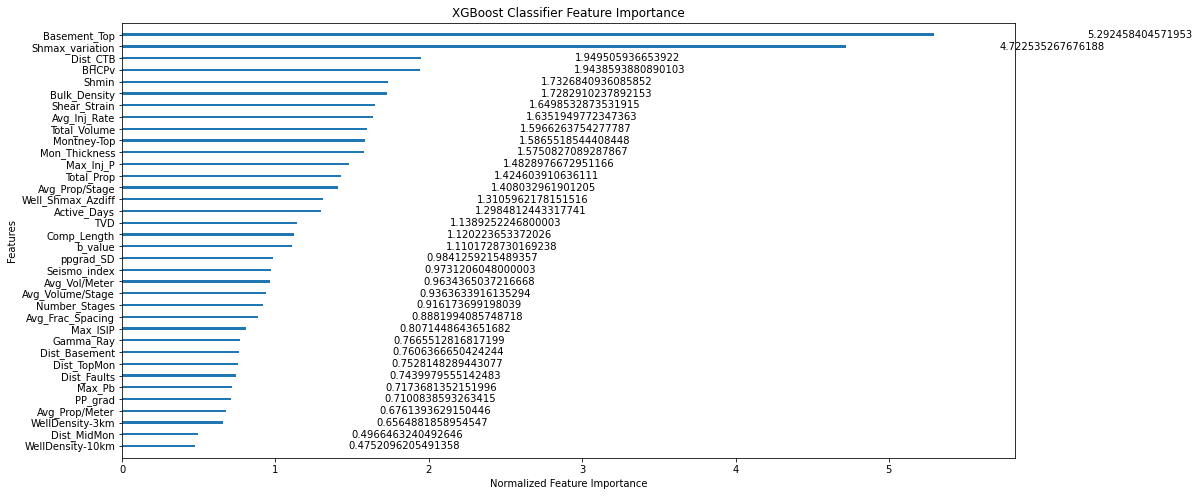

In [29]:
modelxgb = xgb.XGBClassifier(eta= 0.3715548932087601,gamma= 1e-06 , max_depth=32,eval_metric='logloss',use_label_encoder=False).fit(X_train_scaled, y_train)
xgb.plot_importance(modelxgb, importance_type='gain', grid=False)
fig = plt.gcf()
plt.title("XGBoost Classifier Feature Importance")
plt.xlabel("Normalized Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('XGB_C_FI_GOP_200dpi.png', dpi=200)

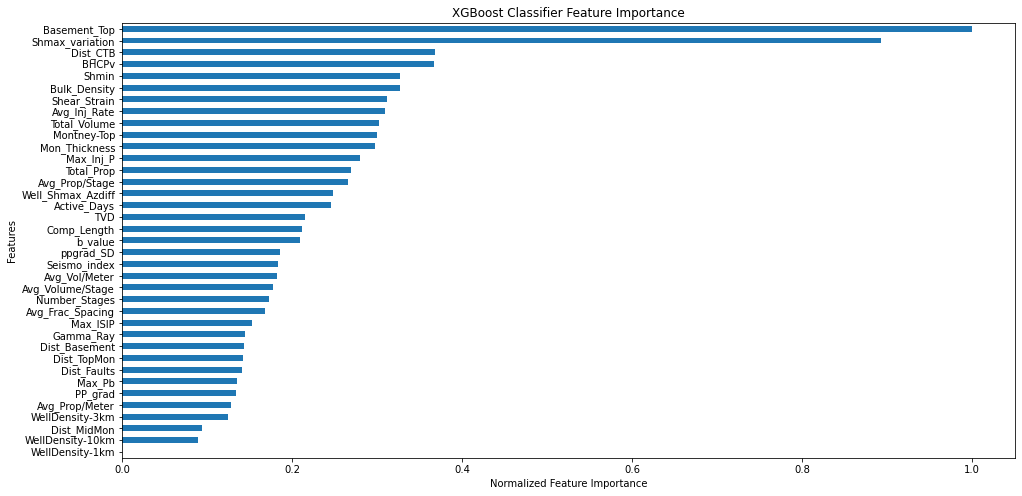

In [54]:
modelxgb = xgb.XGBClassifier(eta= 0.3715548932087601,gamma= 1e-06 , max_depth=32,eval_metric='logloss',use_label_encoder=False,importance_type='gain')
modelxgb.fit(X_train_scaled, y_train)
#feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X_train.columns})
feat_importances = pd.Series(modelxgb.feature_importances_, index=X_train_scaled.columns)
feat_importances = feat_importances.sort_values()/feat_importances.max()
fig = plt.gcf()
plt.title("XGBoost Classifier Feature Importance")
fig.set_figheight(8)
fig.set_figwidth(16)
plt.xlabel("Normalized Feature Importance")
plt.ylabel("Features")
feat_importances.plot(kind='barh')
plt.savefig('XGB_C_FI_GOP_200dpi.png', dpi=200)

## PDP and ICE plts (Light GBM)

In [36]:
# fig, ax = plt.subplots(figsize=(24, 16))
# ax.set_title("Partial dependence plot of geological features\n"
#     "for likelihood of IS events, with LGBM Classifier")
# display = plot_partial_dependence(model, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismogenic_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
#                                ax=ax, n_cols=4)
# display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
# fig.savefig('PDP_lgbmC_100dpi', dpi=100)

In [35]:
# fig, ax = plt.subplots(figsize=(24, 16))
# ax.set_title("Individual Conditional Expectation (ICE) plot\n"
#     "of geological features for likelihood of IS events, with LGBM Classifier")
# display = plot_partial_dependence(model, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismogenic_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Montney-Thikness_CW','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
#                                ax=ax, n_cols=4, kind="both", subsample=100)
# display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
# fig.savefig('ICE_plot_lgbmC_300dpi', dpi=300)

## PDP and ICE plts (Random Forest)

In [33]:
# modelrf = RandomForestClassifier(max_depth= 28).fit(X_train_scaled, y_train)
# fig, ax = plt.subplots(figsize=(24, 16))
# ax.set_title("Partial dependence plot of geological features\n"
#     "for likelihood of IS events, with Random Forest Classifier")
# display = plot_partial_dependence(modelrf, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismo_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Mon_Thickness','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
#                                ax=ax, n_cols=4)
# display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
# fig.savefig('PDP_RF_100dpi', dpi=100)

In [34]:
# fig, ax = plt.subplots(figsize=(24, 16))
# ax.set_title("Individual Conditional Expectation (ICE) plot\n"
#     "of geological features for likelihood of IS events, with Random Forest Classifier")
# display = plot_partial_dependence(modelrf, X_train_scaled, ['Bulk_Density','BHCPv','Gamma_Ray','b_value','Seismo_index','Shear_Strain','Shmin-Mpa','Shmax_variation','PP_grad','ppgrad_std','Montney-Top','Basement','Dist_Faults','Dist_CTB','Max_ISIP','Max_Pb','Dist_TopMon','Dist_MidMon','Dist_Base','Mon_Thickness','WellDensity-1km','WellDensity-3km','WellDensity-10km'],
#                                ax=ax, n_cols=4, kind="both", subsample=100)
# display.figure_.subplots_adjust(wspace=0.1,hspace=0.3)
# fig.savefig('ICE_plot_RFC_100dpi', dpi=100)

## SHAP plots

In [55]:
model = lgb.LGBMClassifier(learning_rate= 0.06649007425065066,max_depth= 8,n_estimators=1000,num_leaves= 100,class_weight='balanced').fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


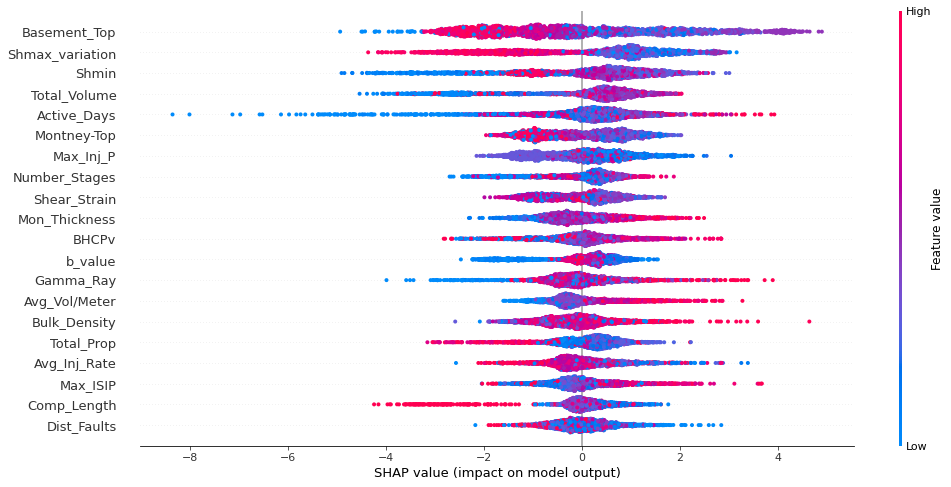

In [56]:
shap.summary_plot(shap_values[1], X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('LGBM_C_GOP_SHAP_summary_200dpi.png', dpi=200)

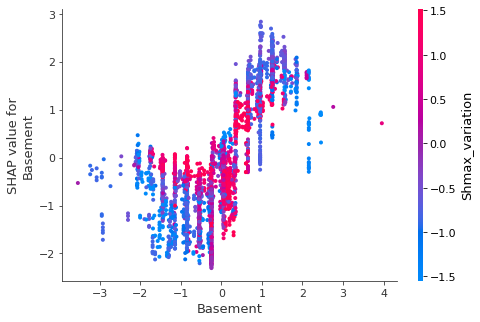

In [33]:
# The first argument is the index of the feature we want to plot
# The second argument is the matrix of SHAP values (it is the same shape as the data matrix)
# The third argument is the data matrix (a pandas dataframe or numpy array)
shap.dependence_plot(11, shap_values[0], X_train_scaled)

In [57]:
modelrf = RandomForestClassifier(max_depth= 62).fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(modelrf)
shap_values = explainer.shap_values(X_train_scaled)

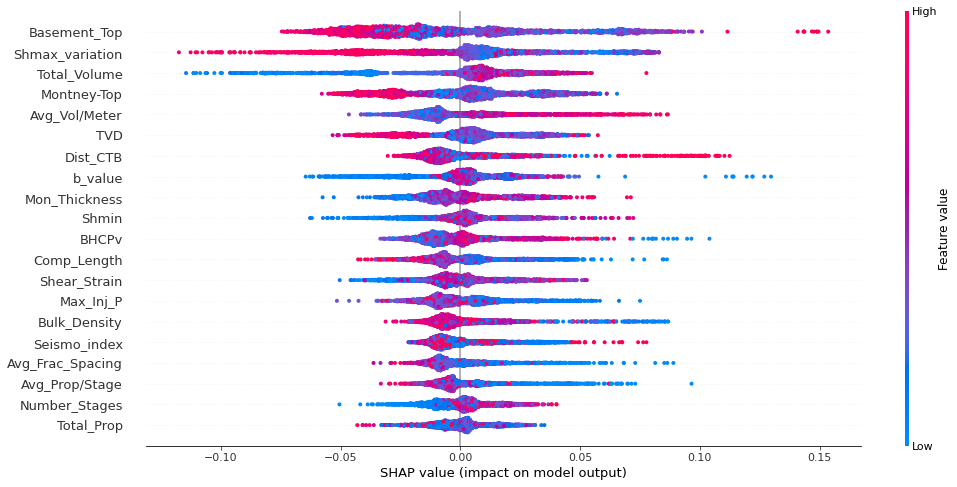

In [58]:
#fig, ax = plt.subplots(figsize=(30, 30))
fig = shap.summary_plot(shap_values[1], X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('RF_C_GOP_SHAP_summary_200dpi.png', dpi=200)

In [19]:
#for name in X_train_scaled.columns:
#    shap.dependence_plot(name, shap_values[1], X_train_scaled)

## XGBoost SHAP

In [59]:
modelxgb = xgb.XGBClassifier(eta= 0.3715548932087601,gamma= 1e-06 , max_depth=32,eval_metric='logloss',use_label_encoder=False).fit(X_train_scaled, y_train)

# compute SHAP values
explainer = shap.TreeExplainer(modelxgb)
shap_values = explainer.shap_values(X_train_scaled)



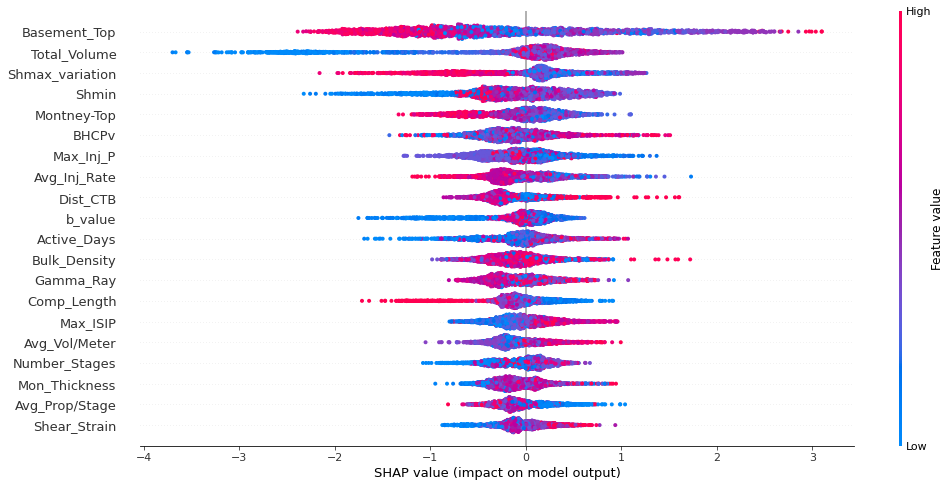

In [60]:
shap.summary_plot(shap_values, X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(16)
plt.savefig('XGBoost_C_GOP_SHAP_summary_200dpi.png', dpi=200)

## SVC SHAP (will take days to run!)

In [9]:
modelsvc = SVC(C= 141927.1570277046,gamma=0.08153866243831843)
modelsvc.fit(X_train_scaled, y_train)
pred_fcn = modelsvc.decision_function

In [10]:
np.random.seed(0)
svm_explainer = KernelShap(pred_fcn)
svm_explainer.fit(X_train_scaled,summarise_background=True)

Using 300 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
Predictor returned a scalar value. Ensure the output represents a probability or decision score as opposed to a classification label!


KernelShap(meta={
  'name': 'KernelShap',
  'type': ['blackbox'],
  'task': 'classification',
  'explanations': ['local', 'global'],
  'params': {
              'link': 'identity',
              'group_names': None,
              'grouped': False,
              'groups': None,
              'weights': None,
              'summarise_background': True,
              'summarise_result': None,
              'transpose': False,
              'kwargs': {}}
            }
)

In [11]:
svm_explanation = svm_explainer.explain(X_test_scaled, l1_reg=False)

  0%|          | 0/839 [00:00<?, ?it/s]

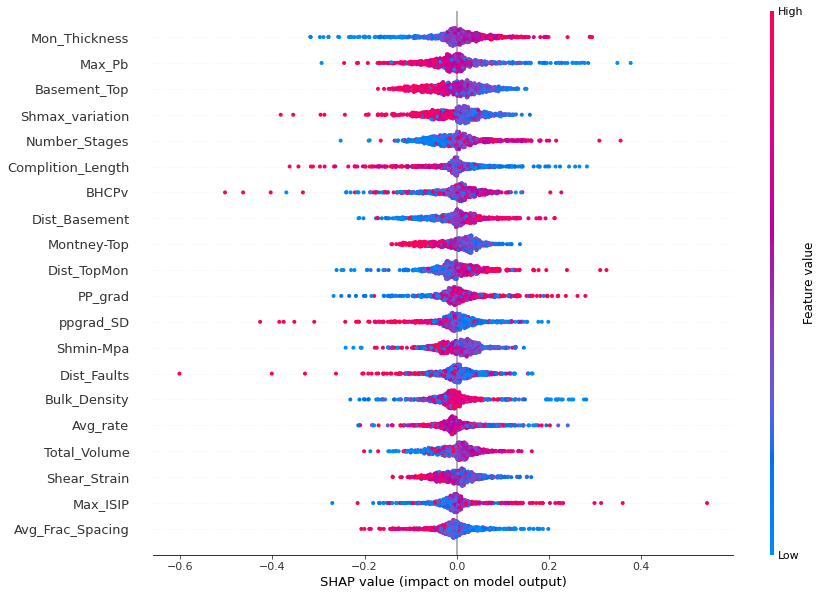

In [19]:
shap.summary_plot(svm_explanation.shap_values[0], X_test_scaled, X_train.columns,show=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(13)
plt.savefig('SVC_C_GOP_SHAP_summary_300dpi.png', dpi=300)

In [ ]:
shap.summary_plot(shap_values, X_train_scaled,show=False)
fig = plt.gcf()
fig.set_figheight(10)
fig.set_figwidth(13)
plt.savefig('SVC_C_GOP_SHAP_summary_200dpi.png', dpi=200)

# Permutated Feature Importance

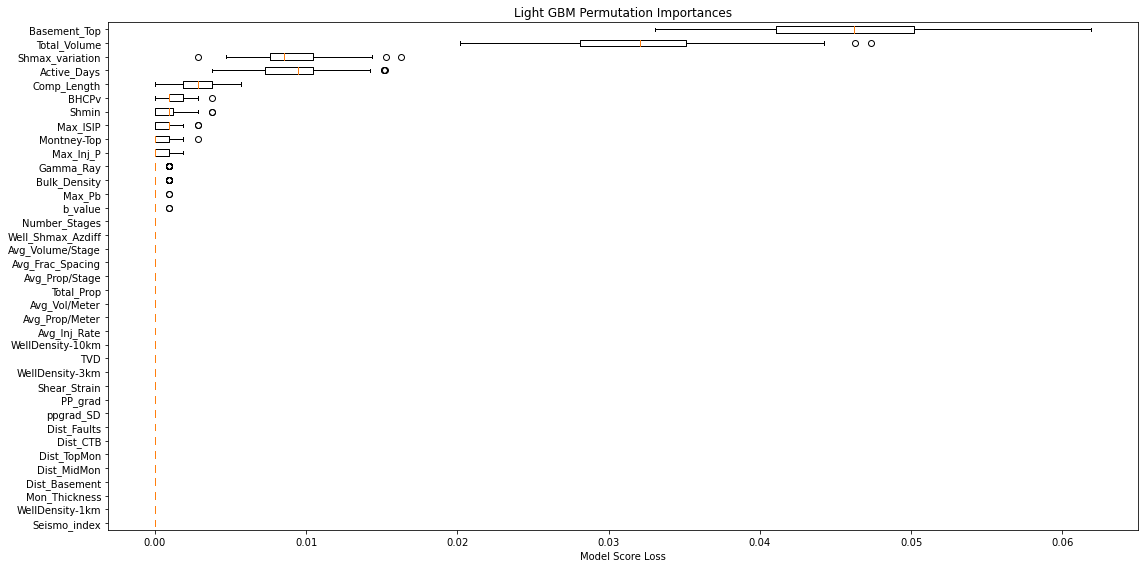

In [61]:
modellgb = lgb.LGBMClassifier(learning_rate= 0.163,max_depth= 32,num_leaves= 100).fit(X_train_scaled, y_train)
result = permutation_importance(modellgb, X_train_scaled, y_train, n_repeats=100,
                                random_state=42, n_jobs=2, scoring= 'f1')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_scaled.columns[sorted_idx])
ax.set_title("Light GBM Permutation Importances")
ax.set_xlabel("Model Score Loss")
fig.tight_layout()
plt.show()
fig.savefig('Permutated_FeatureImportance_LGBM_GOP_200dpi', dpi=200)

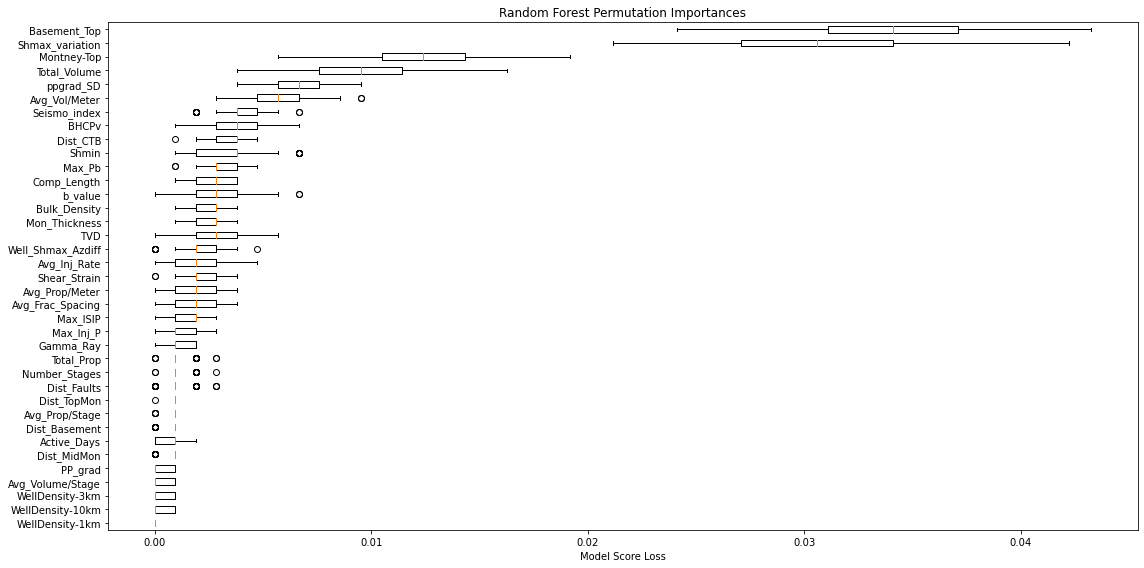

In [62]:
modelrf = RandomForestClassifier(max_depth= 62).fit(X_train_scaled, y_train)
result = permutation_importance(modelrf, X_train_scaled, y_train, n_repeats=100,
                                random_state=42, n_jobs=2, scoring= 'f1')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_scaled.columns[sorted_idx])
ax.set_title("Random Forest Permutation Importances")
ax.set_xlabel("Model Score Loss")
fig.tight_layout()
plt.show()
fig.savefig('Permutated_FeatureImportance_RF_GOP_200dpi', dpi=200)

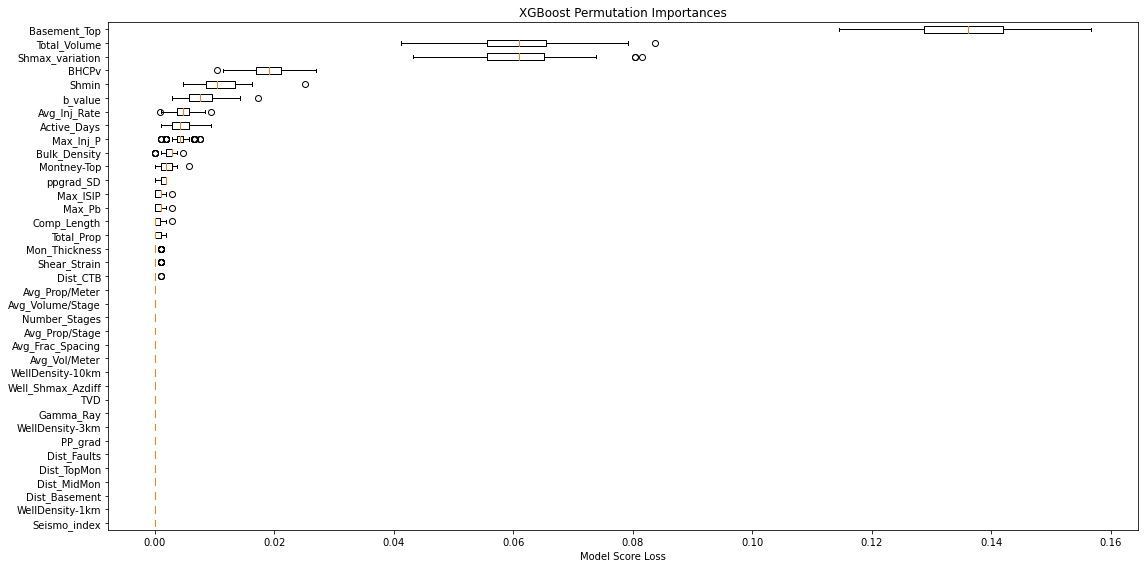

In [63]:
modelxgb = xgb.XGBClassifier(eta= 0.3715548932087601,gamma= 1e-06 , max_depth=32,eval_metric='logloss',use_label_encoder=False).fit(X_train_scaled, y_train)
result = permutation_importance(modelxgb, X_train_scaled, y_train, n_repeats=100,
                                random_state=42, n_jobs=2, scoring= 'f1')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_scaled.columns[sorted_idx])
ax.set_title("XGBoost Permutation Importances")
ax.set_xlabel("Model Score Loss")
fig.tight_layout()
plt.show()
fig.savefig('Permutated_FeatureImportance_XGB_GOP_200dpi', dpi=200)

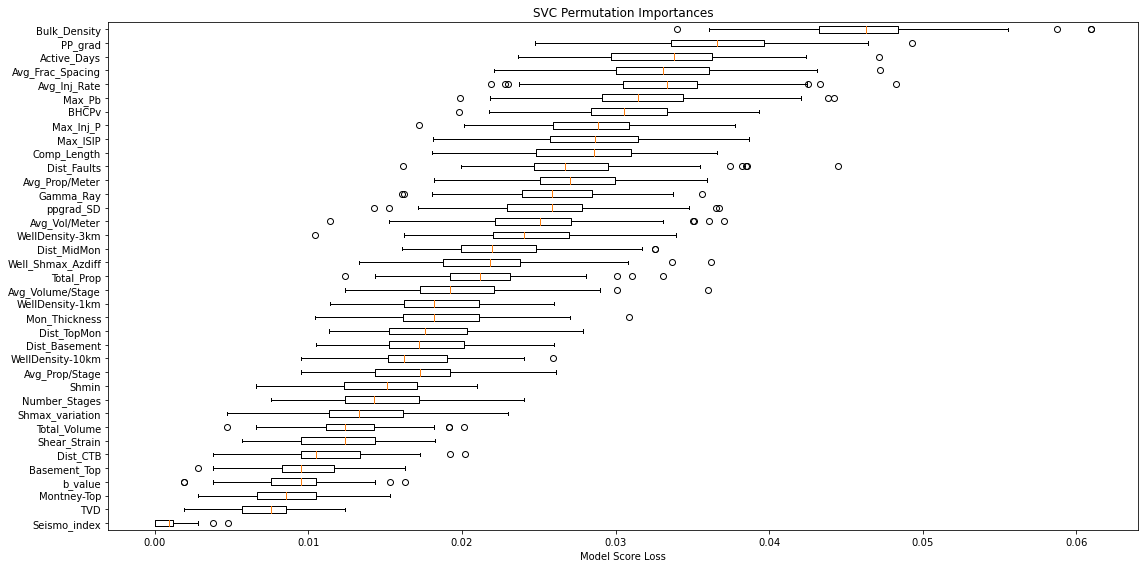

In [64]:
modelsvc = SVC(C= 141927.1570277046,gamma=0.08153866243831843).fit(X_train_scaled, y_train)
result = permutation_importance(modelsvc, X_train_scaled, y_train, n_repeats=100,
                                random_state=42, n_jobs=2, scoring= 'f1')
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(16, 8))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train_scaled.columns[sorted_idx])
ax.set_title("SVC Permutation Importances")
ax.set_xlabel("Model Score Loss")
fig.tight_layout()
plt.show()
fig.savefig('Permutated_FeatureImportance_SVC_GOP_200dpi', dpi=200)

In [21]:
fig.savefig('Permutated_FeatureImportance_SVC_GOP_300dpi', dpi=300)

[17:06:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<Figure size 3200x2400 with 0 Axes>

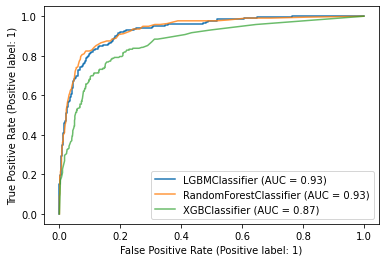

In [38]:
from matplotlib.pyplot import figure
figure(figsize=(16, 12), dpi=200)
modellgb = lgb.LGBMClassifier(learning_rate= 0.02,max_depth= 32,n_estimators=463,num_leaves= 80)
modellgb.fit(X_train_scaled, y_train)
modellgb_disp = plot_roc_curve(modellgb, X_test_scaled, y_test)
modelrf = RandomForestClassifier(max_depth= 28)
modelrf.fit(X_train_scaled, y_train)
ax = plt.gca()
#fig, ax = plt.subplots(figsize=(12, 8))
modelrf_disp = plot_roc_curve(modelrf, X_test_scaled, y_test, ax=ax, alpha=0.8)
#modellgb_disp.plot(ax=ax, alpha=0.8)
modelxgb = xgb.XGBClassifier(eta= 1.66e-05,gamma= 0.046 , max_depth=79,use_label_encoder=False)
modelxgb.fit(X_train_scaled, y_train)
modelxgb_disp = plot_roc_curve(modelxgb, X_test_scaled, y_test, ax=ax, alpha=0.7)
plt.show()
fig.savefig('ROC_200dpi', dpi=200)

# preprocessing grid dataset

In [5]:
X = df_grid.drop(columns=['MiddleMontney','Lower_Form','Dist_Deb/Bell','WellDensity-5km','FID','POINT_X','POINT_Y'])

X_imp = imputer.transform(X)
 
X_scaled = scaler.transform(X_imp) # transforming the train split
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

In [19]:
model = lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=200,num_leaves= 80,class_weight='balanced')
model.fit(X_train_scaled, y_train)
prob = model.predict_proba(X_scaled)
df = pd.DataFrame(prob)
df.to_excel(r'C:\Users\aamini\Desktop\GeoscienceBC Project\Project\lgbprob.xlsx')

In [20]:
prob

array([[0.98730015, 0.01269985],
       [0.98727513, 0.01272487],
       [0.98730015, 0.01269985],
       ...,
       [0.85142413, 0.14857587],
       [0.85581024, 0.14418976],
       [0.85581024, 0.14418976]])

# Results of applying LightGBM model on grid dataset

# Model Result

In [52]:
classifiers = {
    "Random Forest": RandomForestClassifier(max_depth= 28),
    "XGBoost": xgb.XGBClassifier(eta= 1.6630870675319177e-05,gamma= 0.04574552576349154 , max_depth=79,use_label_encoder=False),
    "Light GBM": lgb.LGBMClassifier(learning_rate= 0.019429770022979964,max_depth= 32,n_estimators=200,num_leaves= 80)
                }

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train_scaled, y_train).predict_proba(X_scaled)
    df = pd.DataFrame(y_pred)
#    filename = (i)
    filename = "Montney grid_" + str(key) + ".xlsx"
    df.to_excel(filename)

[16:11:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
